In [1]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from boto3.s3.transfer import TransferConfig
import xarray as xr
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup
import re

from datetime import datetime, timedelta
import os
import shutil
import time

import concurrent.futures
import glob

In [2]:
places_coordinates = {
    "Europe": {'lat_min': 35.25, 'lat_max': 71.75, 'lon_min': -10.25, 'lon_max': 31},
    "Canada": {'lat_min': 44.0, 'lat_max': 70.0, 'lon_min': -141.5, 'lon_max': -51.5}, 
    "US": {'lat_min': 24, 'lat_max': 49, 'lon_min': -125.5, 'lon_max': -65.5},
    "BlackSea": {'lat_min': 41.25, 'lat_max': 57.0, 'lon_min':22.75, 'lon_max': 61.5},
    "Australia": {'lat_min': -39, 'lat_max': -10.5, 'lon_min': 112.75, 'lon_max': 153.25},
    "Argentina": {'lat_min': -56.25, 'lat_max': -21.75, 'lon_min': -75.5, 'lon_max': -51.75}
}

In [3]:
def find_dates(year, max_retries=5, start_date=False):
    retries = 0
    while retries < max_retries:
        try:
            r = requests.get(f'https://tds.gdex.ucar.edu/thredds/catalog/files/g/d084001/{year}/catalog.html', timeout=10)
            break
        except requests.exceptions.RequestException as e:
            retries += 1
            time.sleep(5)
            
    soup = BeautifulSoup(r.text, "html.parser")
    dates = [f.get_text() for f in soup.find_all('code') if re.fullmatch(r"\d{8}", f.get_text())]
    if start_date:
        return [d for d in dates if datetime.strptime(d, '%Y%m%d') >= datetime.strptime(str(start_date), '%Y%m%d')]
    else:
        return dates

In [4]:
def find_files(year, date, run, forecast_horizon, max_retries=5):
    retries = 0
    while retries < max_retries:
        try:
            r = requests.get(f'https://tds.gdex.ucar.edu/thredds/catalog/files/g/d084001/{year}/{date}/catalog.html')
            break
        except requests.exceptions.RequestException as e:
            retries += 1
            time.sleep(5)
            
    soup = BeautifulSoup(r.text, "html.parser")
    files =  [f.get_text() for f in soup.find_all('code') if f.get_text()[-6:] == '.grib2']
    current_run = [f for f in files if f.split('.')[2][-2:] == run  # check if run is 00
                   and int(f.split('.f')[1][:3]) > 0 #remove the first data, where data is initial values of the model and not forecast
                   and int(f.split('.f')[1][:3]) <= forecast_horizon] #where files are max forecast horizon
    return current_run

In [5]:
def download_single_file(year, date, file, coords, filepath, max_retries=5):
    forecast_hour = int(file.split('.f')[1][:3])
    forecast_hour_timedelta = timedelta(hours=forecast_hour)
    ref_date =  datetime.strptime(file.split('.')[2], "%Y%m%d%H")
    final_dt = ref_date + forecast_hour_timedelta
    iso_date = final_dt.strftime("%Y-%m-%dT%H:%M:%SZ")        

    filename = f"gfs.0p25.{iso_date.replace(':','-')}.nc"

    endpoint = "https://tds.gdex.ucar.edu/thredds/ncss/grid/files/g/d084001/"    
    
    var_precip = [
        'Total_precipitation_surface_3_Hour_Accumulation',
        'Total_precipitation_surface_6_Hour_Accumulation',
        'Total_precipitation_surface_Mixed_intervals_Accumulation'
    ]

    for attempt in range(max_retries):
        for var in var_precip:
            try:
                url = (
                    f"{year}/{date}/{file}"
                    f"?var=Temperature_height_above_ground"
                    f"&var={var}"
                    f"&north={coords['lat_max']}&west={coords['lon_min']}"
                    f"&east={coords['lon_max']}&south={coords['lat_min']}"
                    f"&horizStride=1"
                    f"&time_start={iso_date}&time_end={iso_date}"
                    f"&accept=netcdf3"
                )

                r = requests.get(endpoint + url, timeout=10)
                r.raise_for_status()
                content_type = r.headers.get("Content-Type", "").lower()
                if "netcdf" in content_type and len(r.content) > 1000:
                    with open(os.path.join(filepath, filename), "wb") as f:
                        f.write(r.content)
                    return True
                else:
                    continue

            except requests.exceptions.RequestException:
                continue

        time.sleep(1)

    print("Max retries reached. Download failed for", file)
    return False

In [6]:
def process_files(year, date, place):
    time_vars = ['time1', 'time2']
    height_vars = ['height_above_ground1', 'height_above_ground2', 'height_above_ground3']
    precip_vars = ['Total_precipitation_surface_3_Hour_Accumulation', 'Total_precipitation_surface_6_Hour_Accumulation', 'Total_precipitation_surface_Mixed_intervals_Accumulation']
    time_bounds_vars = ['time1_bounds', 'time2_bounds']

    def fix_coords(ds):
        if ds.longitude.max() > 180:
            ds = ds.assign_coords(longitude=((ds.longitude + 180) % 360) - 180)
            ds = ds.sortby("longitude")

        return ds
    
    def normalize_time(ds, var):
        time_dim_candidates = [d for d in ds.dims if d.startswith('time')]
        if not time_dim_candidates:
            raise ValueError("Aucune dimension time trouvée")
        main_time = [d for d in ds[var].dims if d.startswith('time')][0]
        extra_dims = [d for d in time_dim_candidates if d != main_time]
        if extra_dims:
            ds = ds.drop_dims(extra_dims)
        ds = ds.rename({main_time: 'time'})
        return ds
    
    def process_temp(ds):    
        for h in height_vars:
            if h in ds.coords:
                ds = ds.rename({h: 'height_above_ground'})
                break

        if 'Temperature_height_above_ground' in ds.data_vars:
            ds = ds.rename_vars({'Temperature_height_above_ground': 't2m'})

        ds = normalize_time(ds, 't2m')        
        ds = fix_coords(ds)
        
        return ds
    
    def process_precip(ds):
        for var in precip_vars:
            if var in ds.data_vars:
                ds = ds.rename_vars({var: 'tp'})
                break        
        for tb in time_bounds_vars:
            if tb in ds.data_vars:
                ds = ds.rename_vars({tb: 'time_bounds'})
                break

        ds = normalize_time(ds, 'tp')
        ds = fix_coords(ds)
        
        return ds      
    
    ds_temp = xr.open_mfdataset(f'{place}/{year}/{date}/*.nc', engine='netcdf4', preprocess=process_temp)
    ds_precip = xr.open_mfdataset(f'{place}/{year}/{date}/*.nc', engine='netcdf4', preprocess=process_precip)

    ds_precip['time'] = ds_temp.time

    ds = xr.merge([ds_temp, ds_precip])
    t2m_mean = ds.get('t2m').sel(height_above_ground=2).mean(dim='time')

    precip = ds.get(['tp', 'time_bounds'])
    precip_height = [d for d in precip.dims if d.startswith('height_above_ground')]
    if len(precip_height) > 0:
        precip = precip.isel({precip_height[0]:2})
    precip = precip.sel(time=ds.time.dt.hour % 6 == 0)
    bounds = [bound[1] - bound[0] for bound in precip.time_bounds.values]
    bounds_6h = all(x == np.timedelta64(21600000000000, 'ns') for x in bounds)

    if bounds_6h:
        precip_sum = precip.get('tp').sum(dim='time')
    else:
        precip_sum = None

    t2m_df = t2m_mean.to_dataframe().set_index('reftime', append=True)
    t2m_df['t2m'] = t2m_df['t2m'] - 273.15
    precip_df = precip_sum.to_dataframe().set_index('reftime', append=True)

    df = pd.concat([t2m_df, precip_df], axis=1)
    if df.empty:
        print(f'Empty df for {place}/{year}/{date}')
        return 0
    df = df[['t2m', 'tp']]
    df = df.to_parquet(f'{place}/{year}/{date}_processed.parquet')

In [ ]:
years = [i for i in range(2025, 2026)]
for year in years:
    dates = find_dates(year, start_date=20251106)
    for date in dates:
        files = find_files(year, date, '00', 168)
        for place, coords in places_coordinates.items():
            filepath = f'{place}/{year}/{date}'
            os.makedirs(filepath, exist_ok=True)
            files_tuple = [(year, date, file, coords, filepath) for file in files]
            # Télécharger en parallèle
            with concurrent.futures.ThreadPoolExecutor(max_workers=14) as executor:
                futures = [executor.submit(download_single_file, year_, date_, file_, coords_, filepath_) for year_, date_, file_, coords_, filepath_ in files_tuple]
                results = [f.result() for f in futures]
            # Vérifier que tout s'est bien passé
            if all(results):
                for variable in ['Temp', 'Precip']:
                    process_files(year, date, place)
            else:
                failed_files = [file for file, success in zip(files, results) if not success]
                print("Downloads failed for files:", failed_files)

Crop mask

In [9]:
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd

import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np

import os
from datetime import timedelta
from concurrent.futures import ProcessPoolExecutor

def extract_wheat_zones_from_geoglam(winter_wheat_tif, spring_wheat_tif, region, output_geojson_path, coverage_threshold_percent=10, min_area_km2=100, 
                                          buffer_distance=0.25):

    threshold_value = coverage_threshold_percent * 100

    def read_wheat_layer(tif_file_path, region):        
        with rasterio.open(tif_file_path) as src:
            europe = pd.read_parquet(f'{region}/2015/20150115_processed.parquet')

            latitudes = europe.index.get_level_values('latitude').unique()
            longitudes = europe.index.get_level_values('longitude').unique()

            lat_min, lat_max = latitudes.min(), latitudes.max()
            lon_min, lon_max = longitudes.min(), longitudes.max()

            window = rasterio.windows.from_bounds(
            lon_min, lat_min, lon_max, lat_max,
            transform=src.transform
            )
            data = src.read(1, window=window)
            wheat_mask = (data >= threshold_value).astype(np.uint8)
            transform = src.window_transform(window)
            crs = src.crs

        return wheat_mask, transform, crs
    
    winter_mask, transform, crs = read_wheat_layer(winter_wheat_tif, region)
    spring_mask, _, _ = read_wheat_layer(spring_wheat_tif, region)

    assert winter_mask.shape == spring_mask.shape
    wheat_mask = np.maximum(winter_mask, spring_mask)

    geometries = []
    for geom, value in shapes(wheat_mask, transform=transform):
        if value == 1:
            geometries.append(shape(geom))
            
    gdf = gpd.GeoDataFrame(
            geometry=geometries,
            crs=crs
        )
    gdf_area = gdf.to_crs('EPSG:3857')  # Projection métrique
    gdf['area_km2'] = gdf_area.geometry.area / 1e6

    gdf_buffered = gdf.copy()
    # Reprojeter en système métrique pour le buffer
    gdf_buffered = gdf_buffered.to_crs('EPSG:3857')  # Web Mercator
    buffer_distance_meters = buffer_distance * 111000
    gdf_buffered['geometry'] = gdf_buffered.geometry.buffer(buffer_distance_meters)
    gdf_dissolved = gdf_buffered.dissolve()
    gdf_dissolved['geometry'] = gdf_dissolved.geometry.buffer(-(buffer_distance_meters))
    # Reprojeter en WGS84
    gdf_dissolved = gdf_dissolved.to_crs('EPSG:4326')
    gdf = gdf_dissolved.explode(index_parts=True).reset_index(drop=True)

    # Recalculer les surfaces
    gdf_area = gdf.to_crs('EPSG:3857')
    gdf['area_km2'] = gdf_area.geometry.area / 1e6

    gdf = gdf[gdf['area_km2'] >= min_area_km2].copy()

    gdf.to_file(output_geojson_path, driver='GeoJSON')

    return gdf

In [10]:
def extract_wheat_for_all_regions(region_configs, output_dir='CropFilter'):
    results = {}
    for region, config in region_configs.items():
        output_path = f'{output_dir}/{region.lower()}.geojson'

        try:
            gdf = extract_wheat_zones_from_geoglam(config['winter_wheat_path'], config['spring_wheat_path'], region, output_path, 
                                                   coverage_threshold_percent=config['coverage_threshold_percent'], min_area_km2=config['min_area_km2'],
                                                   buffer_distance=config['buffer_distance'])
            if not gdf.empty:
                results[region] = gdf
            else: 
                print(f'{region} has no data')
        except Exception as e:
            print(f"Error for {region}: {e}")
            
    return results

In [11]:
def create_mask_from_geojson(geojson_path, output_path, resolution=0.25):
    zones = gpd.read_file(geojson_path)

    # Obtenir les limites
    bounds = zones.total_bounds

    # Arrondir les bounds à la grille de résolution
    # Floor pour min, ceil pour max pour être sûr de tout couvrir
    lon_min = np.floor(bounds[0] / resolution) * resolution
    lat_min = np.floor(bounds[1] / resolution) * resolution
    lon_max = np.ceil(bounds[2] / resolution) * resolution
    lat_max = np.ceil(bounds[3] / resolution) * resolution

    # Générer la grille (toutes les combinaisons lat/lon à 0.25°)
    lats = np.arange(lat_min, lat_max + resolution, resolution)
    lons = np.arange(lon_min, lon_max + resolution, resolution)

    # Créer tous les points
    lat_grid, lon_grid = np.meshgrid(lats, lons, indexing='ij')
    coords_flat = list(zip(lon_grid.ravel(), lat_grid.ravel()))

    gdf = gpd.GeoDataFrame({'latitude': [c[1] for c in coords_flat], 'longitude': [c[0] for c in coords_flat]},
                            geometry=gpd.points_from_xy([c[0] for c in coords_flat], [c[1] for c in coords_flat]),
                            crs="EPSG:4326")
    joined = gpd.sjoin(gdf, zones, how="left", predicate="within")

    # Supprimer les points hors zones
    mask = joined.copy()
    mask = mask.dropna()

    mask.to_parquet(output_path)
    
    return mask

In [12]:
def create_mask_for_all_region(region_configs, output_dir='CropFilter'):
    masks = {}
    for region in region_configs.keys():
        output_path = f'{output_dir}/{region.lower()}_mask.parquet'

        try:
            mask = create_mask_from_geojson(f'CropFilter/{region.lower()}.geojson', output_path)

            if not mask.empty:
                masks[region] = mask
            else: 
                print(f'{region} has no data')
        except Exception as e:
            print(f"Error for {region}: {e}")
            
    return masks

In [13]:
def process_daily_file(file_path, mask, date_str=None):

    df = pd.read_parquet(file_path)
    mask = mask.set_index(['latitude', 'longitude'])

    # Joindre avec le masque (conserve uniquement les points dans les zones)
    df_with_region = df.join(mask, how='inner')
    df_with_region = df_with_region.reset_index()

    # Si pas de date fournie, essayer de l'extraire du nom de fichier
    if date_str is None:
        # Assumer format type "20240115_processed.parquet"
        date_str = file_path.split('/')[2].split('_')[0]
    
    # Calculer les moyennes par zone
    region_mean = df_with_region[['t2m', 'tp', 'reftime']].groupby('reftime').mean().reset_index()
    
    region_mean['date_forecast'] = pd.to_datetime(date_str) + timedelta(days=7)
    
    return region_mean

In [14]:
def process_region_year(region_name, year, mask):
    year_path = f'{region_name}/{year}/'
    region_year_files = sorted(os.listdir(year_path))
    
    results = []
    for file in region_year_files:
        try:
            daily_result = process_daily_file(year_path + file, mask)
            results.append(daily_result)
        except Exception as e:
            print(f"Error on {file}: {e}")
        
    year_df = pd.concat(results)
    year_df['region'] = region_name
    year_df['year'] = year

    return year_df

In [ ]:
def process_all_data(regions, years, masks, output_path='../../data/weather/wheat_zones_gfs.parquet'):
    #Make process_region_year concurrent ? 
    results = []
                
    for region in regions:
        for year in years:
            try:
                df = process_region_year(region, year, masks[region])
                if not df.empty:
                    results.append(df)
            except Exception as e:
                print(f"Error on {region}/{year}: {e}")
        print(f'{region} {year} done')

    if results:
        final_df = pd.concat(results, ignore_index=True)
        final_df.to_parquet(output_path, index=False)
        
        return final_df
    else:
        print("No results")
        return None

In [16]:
region_configs = {
    'Europe': {
        'coverage_threshold_percent':15, 
        'min_area_km2':150,
        'buffer_distance':0.25,
        'winter_wheat_path': 'Geoclam/Percent_Winter_Wheat.tif',
        'spring_wheat_path': 'Geoclam/Percent_Spring_Wheat.tif'
    },
    'US': {
        'coverage_threshold_percent':15, 
        'min_area_km2':300,
        'buffer_distance':0.25,
        'winter_wheat_path': 'Geoclam/Percent_Winter_Wheat.tif',
        'spring_wheat_path': 'Geoclam/Percent_Spring_Wheat.tif'
    },
    'Australia': {
        'coverage_threshold_percent':10, 
        'min_area_km2':100,
        'buffer_distance':0.25,
        'winter_wheat_path': 'Geoclam/Percent_Winter_Wheat.tif',
        'spring_wheat_path': 'Geoclam/Percent_Spring_Wheat.tif'
    },
    'Argentina': {
        'coverage_threshold_percent':15, 
        'min_area_km2':150,
        'buffer_distance':0.25,
        'winter_wheat_path': 'Geoclam/Percent_Winter_Wheat.tif',
        'spring_wheat_path': 'Geoclam/Percent_Spring_Wheat.tif'
    },
    'BlackSea': {
        'coverage_threshold_percent':30, 
        'min_area_km2':150,
        'buffer_distance':0.25,
        'winter_wheat_path': 'Geoclam/Percent_Winter_Wheat.tif',
        'spring_wheat_path': 'Geoclam/Percent_Spring_Wheat.tif'
    },
    'Canada': {
        'coverage_threshold_percent':15, 
        'min_area_km2':300,
        'buffer_distance':0.25,
        'winter_wheat_path': 'Geoclam/Percent_Winter_Wheat.tif',
        'spring_wheat_path': 'Geoclam/Percent_Spring_Wheat.tif'
    }
}

In [ ]:
years = [year for year in range(2015, 2026)]
regions = region_configs.keys()

res = extract_wheat_for_all_regions(region_configs)
masks = create_mask_for_all_region(region_configs)
df = process_all_data(regions, years, masks)

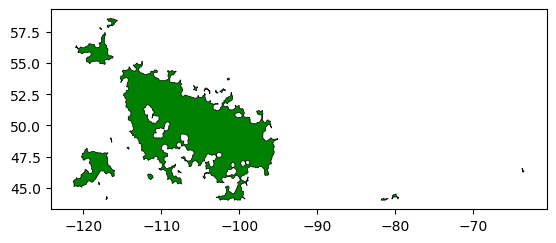

In [90]:
import matplotlib.pyplot as plt

res['Canada'].plot(color='green', edgecolor='black', linewidth=0.5)

plt.show()